In [1]:
import warnings
warnings.filterwarnings("ignore")

import fastai.utils
from fastai.vision import *
from fastai.callbacks import *

from knockknock import email_sender

In [2]:
fastai.utils.collect_env.show_install()



```text
=== Software === 
python        : 3.7.7
fastai        : 1.0.61
fastprogress  : 0.2.2
torch         : 1.5.0
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : GeForce RTX 2080

=== Environment === 
platform      : Linux-4.19.121-microsoft-standard-x86_64-with-debian-buster-sid
distro        : #1 SMP Fri Jun 19 21:06:10 UTC 2020
conda env     : base
python        : /home/yyang/miniconda3/bin/python
sys.path      : /home/yyang/python
/home/yyang/miniconda3/lib/python37.zip
/home/yyang/miniconda3/lib/python3.7
/home/yyang/miniconda3/lib/python3.7/lib-dynload

/home/yyang/miniconda3/lib/python3.7/site-packages
/home/yyang/miniconda3/lib/python3.7/site-packages/IPython/extensions
/home/yyang/.ipython
no nvidia-smi is found
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics c

In [3]:
path = Path('..').absolute()
data_path = path / 'data' / 'chest_xray'
model_path = path / 'models' / 'chest_xray'

In [4]:
sz = 256
lr = defaults.lr
bs = 32

In [5]:
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

def valid_func(o):
    return 'test' in str(o)

def label_func(o):
    name = o.name
    if 'virus' in name:
        return 'pneumonia'
    if 'bacteria' in name:
        return 'pneumonia'
    return 'normal'

data = (ImageList.from_folder(data_path)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        .transform(get_transforms(), size=sz)
        .databunch(bs=bs)
        .normalize(stats)
        )

data, data.classes

(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /home/yyang/python/../data/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
 y: CategoryList
 normal,normal,normal,normal,normal
 Path: /home/yyang/python/../data/chest_xray;
 
 Test: None,
 ['normal', 'pneumonia'])

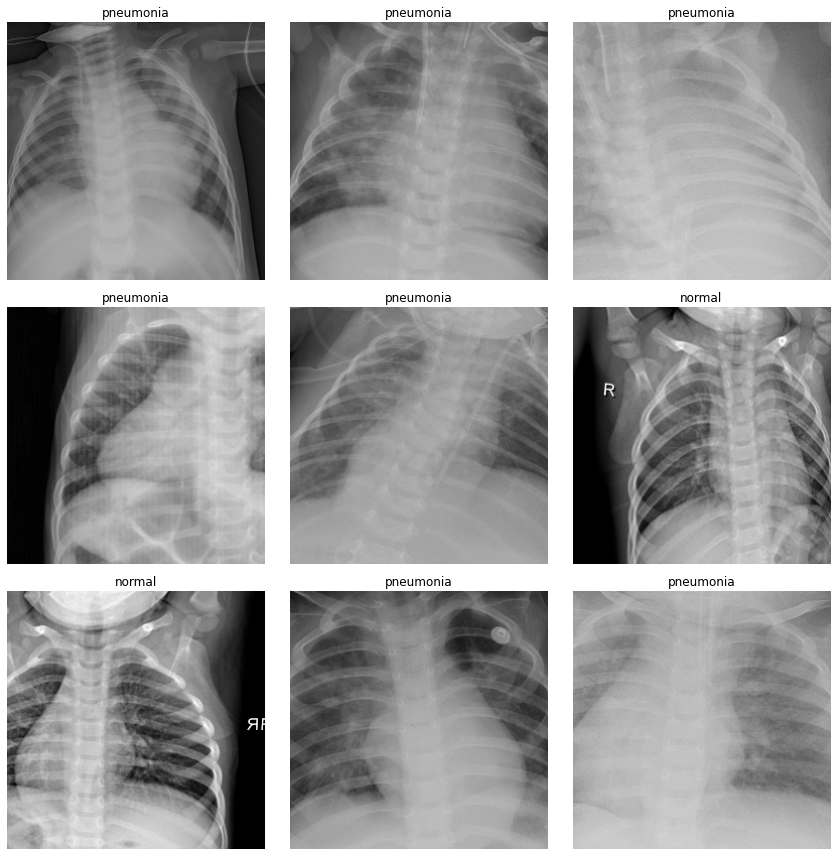

In [6]:
data.show_batch(rows=3)

In [7]:
learn = cnn_learner(data, 
                    models.resnet50,
                    bn_wd=False,
                    metrics=error_rate,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[BnFreeze,
                                  partial(SaveModelCallback, monitor='error_rate', name='best_error')
                                 ],
                    model_dir=model_path,
                   ).to_fp16()

In [8]:
@email_sender(recipient_emails=["yyang@hbku.edu.qa"], sender_email="hbkubot@gmail.com")
def train(learn, name, lr, n_epoch=5):
    learn.fit_one_cycle(n_epoch, lr)
    learn.save(name)

In [9]:
train(learn, 'stage_1', lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.557796,0.619372,0.169872,01:53
1,0.347121,0.422711,0.126603,01:54
2,0.316434,0.461674,0.139423,01:52
3,0.290683,0.384626,0.100962,01:57
4,0.278871,0.390167,0.108974,01:55


Better model found at epoch 0 with error_rate value: 0.16987179219722748.
Better model found at epoch 1 with error_rate value: 0.12660256028175354.
Better model found at epoch 3 with error_rate value: 0.10096153616905212.


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 1.32E-07


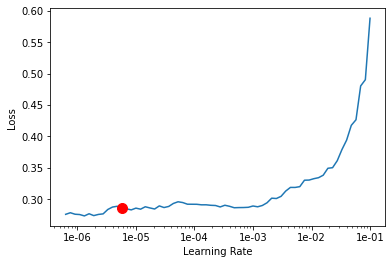

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
lr = 3e-4
train(learn, 'stage_2', lr=slice(lr/100, lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.269235,0.362633,0.094551,02:29
1,0.261076,0.389897,0.107372,02:26
2,0.253807,0.354304,0.086538,02:23
3,0.244908,0.344406,0.089744,02:28
4,0.238169,0.363676,0.097756,02:29


Better model found at epoch 0 with error_rate value: 0.09455128014087677.
Better model found at epoch 2 with error_rate value: 0.08653846383094788.


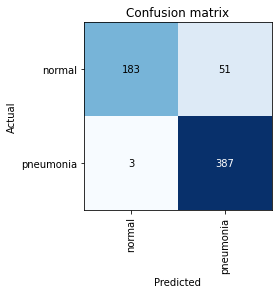

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()